<a href="https://colab.research.google.com/github/ll3091/ANLY-590-02-Neural-Nets-and-Deep-Learning/blob/master/HW2LL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linda Li
## ANLY-590-02 HW2

In [0]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import Conv1D, MaxPooling1D, UpSampling2D, LSTM
from keras.datasets import fashion_mnist
from keras.applications import VGG16
from keras import backend as K

%matplotlib inline
%pylab inline

# change printing precision for numpy variables
np.set_printoptions(precision=4)

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


# 1 Autoencoder

Let's build and fit a convolutional autoencoder for the Fashion MNIST dataset. The encoder part of the network will run the input image through a few convolutional layers. The decoder part of the network will utilize UpSampling2D to get the representation back to the originial image size.

First, let's load the data and look at the shape.

In [0]:
# load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# check shape of data
x_train.shape

(60000, 28, 28)

A Conv2D layer requires a 4D tensor, so we need to reshape our data.

In [0]:
# reshape to add channel dimension
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [0]:
# check new shape of data
x_train.shape

(60000, 28, 28, 1)

Now, let's build and train our autoencoder.

Code below is adapted from https://blog.keras.io/building-autoencoders-in-keras.html and lecture notebooks.

In [0]:
# build a convolutional autoencoder
conv_autoenc = Sequential()

# encoder
conv_autoenc.add(Conv2D(filters = 32, kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='same', input_shape=(28, 28, 1),
                 data_format="channels_last"))
conv_autoenc.add(MaxPooling2D(pool_size=(2,2), padding='same'))

conv_autoenc.add(Conv2D(filters = 16, kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='same'))
conv_autoenc.add(MaxPooling2D(pool_size=(2,2), padding='same'))

conv_autoenc.add(Conv2D(filters = 8, kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='same'))
conv_autoenc.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# decoder
conv_autoenc.add(Conv2D(filters = 8, kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='same'))
conv_autoenc.add(UpSampling2D(size=(2, 2)))

conv_autoenc.add(Conv2D(filters = 16, kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='same'))
conv_autoenc.add(UpSampling2D(size=(2, 2)))

conv_autoenc.add(Conv2D(filters = 32, kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1)))
conv_autoenc.add(UpSampling2D(size=(2, 2)))

conv_autoenc.add(Conv2D(filters = 1, kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='same'))

# display model summary
conv_autoenc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 8)           584       
__________

In [0]:
# compile model
conv_autoenc.compile(optimizer='adadelta', loss='mean_squared_error')

In [0]:
# ~ 1 min to train
conv_autoenc.fit(x_train, x_train, epochs=10, batch_size=500, shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 143us/step - loss: 4173.5824 - val_loss: 3499.0745
Epoch 2/10
60000/60000 [==============================] - 5s 76us/step - loss: 2694.0597 - val_loss: 2568.3039
Epoch 3/10
60000/60000 [==============================] - 5s 76us/step - loss: 2332.4944 - val_loss: 2539.2194
Epoch 4/10
60000/60000 [==============================] - 5s 75us/step - loss: 2126.9767 - val_loss: 2467.2058
Epoch 5/10
60000/60000 [==============================] - 5s 76us/step - loss: 2003.0154 - val_loss: 2213.5366
Epoch 6/10
60000/60000 [==============================] - 5s 76us/step - loss: 1902.2775 - val_loss: 2016.1154
Epoch 7/10
60000/60000 [==============================] - 5s 75us/step - loss: 1820.9971 - val_loss: 1966.1236
Epoch 8/10
60000/60000 [==============================] - 5s 76us/step - loss: 1764.6544 - val_loss: 2181.3637
Epoch 9/10
60000/60000 [==============================] - 5s 

Let's visualize some examples of input images and their decoded reconstruction.

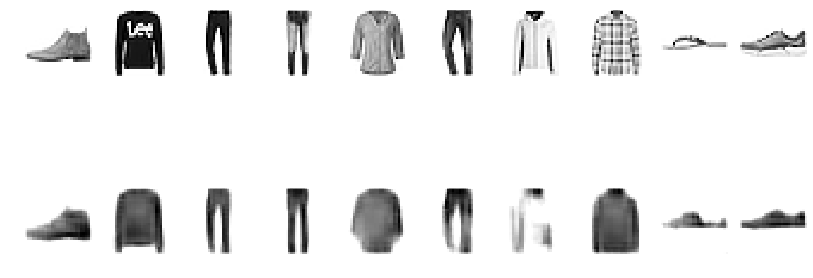

In [0]:
# visualize some input images and their decoded reconstruction
n=10
plt.figure(figsize=(14, 6))
for k in range(n):
    ax = plt.subplot(2, n, k+1)    
    plt.grid(False)
    plt.axis('off')
    plt.imshow(x_test[k:k+1,:].reshape((28,28)))
    ax = plt.subplot(2, n, k+1 + n)
    plt.grid(False)
    plt.axis('off')
    reconstruction = conv_autoenc.predict(x_test[k:k+1,:])
    reconstruction.resize((28,28))
    plt.imshow(reconstruction)
plt.show()

The decoded reconstructions are able to retain the general shape of each article of clothing. However, details like text and patterns are lost. For example, the plaid shirt still looks like a shirt but the stripes are gone Also, the reconstruction of the white jacket seems to indicate that the autoencoder doesn't perform well on lighter pieces of clothing.

# 2 Image Classification

We'll continue to use the Fashion MNIST dataset to build a deep convolutional network for classification.

Let's take a look at our classification labels.

In [0]:
# number of unique labels
len(set(y_train))

10

In [0]:
# shape of labels
y_train.shape

(60000,)

Let's convert our labels to one-hot encodings.

In [0]:
# convert to one-hot-encoded labels
Y_train = keras.utils.to_categorical(y_train, 10)
Y_test = keras.utils.to_categorical(y_test, 10)

In [0]:
# shape of new labels
Y_train.shape

(60000, 10)

## 2.1 Deep CNN

First, we'll build a deep CNN to classify the images. The following model as 2 convolutional layers. The first layer has 64 filters,   2 by 2 kernels, 1 by 1 stride, ReLu activation, and no padding. The latter is like the first with fewer filters and a larger stride - 32 filters and 2 by 2 stride. Next, 2 by 2 blocks of data are max pooled. There is then a dropout rate of 0.25 followed by a layer to flatten the data into a vector. The next layer has 100 hidden nodes with ReLu activation. There is another dropout rate of 0.25. Finally, the output layer has 10 nodes and uses the softmax function.

In [0]:
# build model
CNNmod1 = Sequential()
CNNmod1.add(Conv2D(filters = 64, kernel_size=(2, 2), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28, 28, 1)))
CNNmod1.add(Conv2D(filters = 32, kernel_size=(2, 2), 
                 activation='relu', strides=(2, 2), 
                 padding='valid'))
CNNmod1.add(MaxPooling2D(pool_size=(2,2)))
CNNmod1.add(Dropout(0.25))
CNNmod1.add(Flatten())
CNNmod1.add(Dense(100, activation='relu'))
CNNmod1.add(Dropout(0.25))
CNNmod1.add(Dense(10, activation='softmax'))

# display model summary
CNNmod1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 27, 27, 64)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 32)        8224      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
__________

In [0]:
# compile model
CNNmod1.compile(loss="categorical_crossentropy", optimizer=RMSprop(), metrics=["acc"])

In [0]:
# ~1 min to train
deepCNN = CNNmod1.fit(x_train, Y_train, epochs=20,
                batch_size=500, shuffle=True,
                validation_data=(x_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 81us/step - loss: 1.4914 - acc: 0.7050 - val_loss: 0.4833 - val_acc: 0.8243
Epoch 2/20
60000/60000 [==============================] - 4s 60us/step - loss: 0.4971 - acc: 0.8189 - val_loss: 0.4234 - val_acc: 0.8462
Epoch 3/20
60000/60000 [==============================] - 4s 60us/step - loss: 0.4334 - acc: 0.8403 - val_loss: 0.3846 - val_acc: 0.8586
Epoch 4/20
60000/60000 [==============================] - 4s 60us/step - loss: 0.4019 - acc: 0.8527 - val_loss: 0.3799 - val_acc: 0.8624
Epoch 5/20
60000/60000 [==============================] - 4s 60us/step - loss: 0.3759 - acc: 0.8614 - val_loss: 0.3515 - val_acc: 0.8686
Epoch 6/20
60000/60000 [==============================] - 4s 60us/step - loss: 0.3576 - acc: 0.8670 - val_loss: 0.3513 - val_acc: 0.8727
Epoch 7/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.3430 - acc: 0.8726 - val_loss: 0.3449 - val_acc

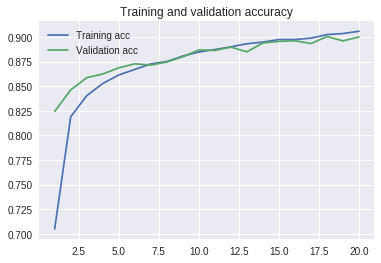

In [0]:
# plot performance
acc = deepCNN.history['acc']
val_acc = deepCNN.history['val_acc']
loss = deepCNN.history['loss']
val_loss = deepCNN.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label = 'Training acc')
plt.plot(epochs, val_acc, label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

The model is able to attain pretty good training and test accuracies of 90.6% and 90.0%, respectively with very little training. The model doesn't appear to be overfitting.

## 2.2 Transfer Learning

Next, we'll utilize a pre-trained network for the majority of our model and only train the final Dense layer. All other weights will be fixed. Here, we'll use the pre-trained VGG16 model weights.

In [0]:
# get pre-training model and weights
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

58892288/58889256 [==============================] - 4s 0us/step


We need to do some preprocessing to ensure that our data is compatible with the pre-trained model. For this model, we need data with 3 input channels and height and width of at least 32.

In [0]:
# pad images so they're compatible with VGG model
x_train32 = np.array([np.pad(x_train[i,:,:,0], 2, 'constant') 
                      for i in range(x_train.shape[0])])
x_test32 = np.array([np.pad(x_test[i,:,:,0], 2, 'constant') 
                     for i in range(x_test.shape[0])])
# create 3 channels by duplicating 
x_train32 = np.stack((x_train32,)*3, axis=-1)
x_test32 = np.stack((x_test32,)*3, axis=-1)
# check new shape
x_test32.shape

(10000, 32, 32, 3)

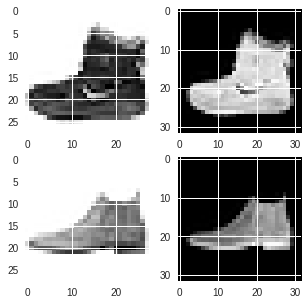

In [0]:
# plot a couple of the original and new padded images
plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
plt.imshow(x_train[0,:,:,0])

plt.subplot(2, 2, 2)
plt.imshow(x_train32[0,:,:,:])

plt.subplot(2, 2, 3)
plt.imshow(x_test[0,:,:,0])

plt.subplot(2, 2, 4)
plt.imshow(x_test32[0,:,:,:])

plt.show()

The following model uses the pre-trained VGG16 model. There is a dropout rate of 0.25. The output is then flattened and is followed by a dense layer with 200 hidden nodes and ReLu activation. Then there is a dropout rate of 0.25. Finally, the output layer has 10 nodes and uses the softmax function.

In [0]:
# build the model
CNNmod2 = Sequential()
CNNmod2.add(conv_base)
CNNmod2.add(Dropout(0.25))
CNNmod2.add(Flatten())
CNNmod2.add(Dense(200, activation='relu'))
CNNmod2.add(Dropout(0.25))
CNNmod2.add(Dense(10, activation='softmax'))

In [0]:
# fix base weights
conv_base.trainable = False
CNNmod2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               102600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2010      
Total params: 14,819,298
Trainable params: 104,610
Non-trainable params: 14,714,688
__________________________________________________________

In [0]:
# compile model
CNNmod2.compile(loss="categorical_crossentropy", optimizer=RMSprop(), metrics=["acc"])

In [0]:
# ~5 mins to train
transferCNN = CNNmod2.fit(x_train32, Y_train, epochs=20,
                batch_size=500, shuffle=True,
                validation_data=(x_test32, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 314us/step - loss: 2.6821 - acc: 0.6426 - val_loss: 0.7524 - val_acc: 0.7496
Epoch 2/20
60000/60000 [==============================] - 16s 272us/step - loss: 0.8502 - acc: 0.7204 - val_loss: 0.5879 - val_acc: 0.7935
Epoch 3/20
60000/60000 [==============================] - 16s 272us/step - loss: 0.6848 - acc: 0.7612 - val_loss: 0.5504 - val_acc: 0.7995
Epoch 4/20
60000/60000 [==============================] - 16s 273us/step - loss: 0.6219 - acc: 0.7790 - val_loss: 0.5109 - val_acc: 0.8166
Epoch 5/20
60000/60000 [==============================] - 16s 272us/step - loss: 0.5912 - acc: 0.7875 - val_loss: 0.4920 - val_acc: 0.8200
Epoch 6/20
60000/60000 [==============================] - 16s 273us/step - loss: 0.5670 - acc: 0.7984 - val_loss: 0.4761 - val_acc: 0.8245
Epoch 7/20
60000/60000 [==============================] - 16s 272us/step - loss: 0.5505 - acc: 0.8027 - val_loss: 0.

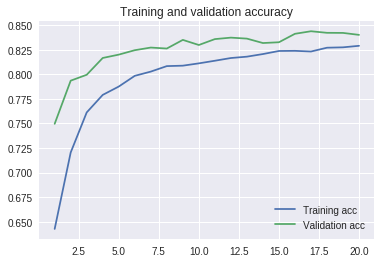

In [0]:
# plot performance
acc = transferCNN.history['acc']
val_acc = transferCNN.history['val_acc']
loss = transferCNN.history['loss']
val_loss = transferCNN.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label = 'Training acc')
plt.plot(epochs, val_acc, label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

This model does not perform as well as the previous model, achieving training and test accuracies of 82.9% and 84.0%, respectively, after a similar amount of training . The VGG16 model will probably work better on more complex and higher quality images. Since the images in our dataset are 28 by 28, a simple CNN model seems to be sufficient for this classification problem.

# 3 Text Classification

In this problem, we will tackle the task of text classification in the context of cybersecurity. In particular, we will build models to classify URLs as malicious or benign. 

Let's download the data and prepare it for training.

In [0]:
# download labeled dataset for text classification
! wget "https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt"
! wget "https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt"

--2018-11-21 22:27:19--  https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.100.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.100.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2045721 (2.0M) [text/plain]
Saving to: ‘benign-urls.txt’

benign-urls.txt     100%[===================>]   1.95M  4.02MB/s    in 0.5s    

2018-11-21 22:27:20 (4.02 MB/s) - ‘benign-urls.txt’ saved [2045721/2045721]

--2018-11-21 22:27:21--  https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.100.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.100.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21732 (21K) [text/plain]
Saving to: ‘malicious-urls.txt’

malicious-urls.txt  100%[===================>]  21.22K  --.-KB/s    in 0.08s   

2018-11-21 22:27:22 (258 KB/s) - ‘malicious-urls.txt

In [0]:
# look at structure of text file
! cat benign-urls.txt | head

# GOOGLE
.0.blogger.gmodules.com
.0.client-channel.google.com
.0.docs.google.com
.0.drive.google.com
.0.gvt0.cn
.0.gvt0.com
.10.client-channel.google.com
.10.docs.google.com
.10.drive.google.com


In [0]:
# look at structure of text file
! cat malicious-urls.txt | head

.1337x.pl
.1link.io
.1n.pm
.22apple.com
.22find.com
.2s5m19yk.ru
.301.li
.3utilities.com
.44d.info
.4everproxy.co


In [0]:
# read in data, dropping lines that start with '#'
with open("benign-urls.txt", 'r') as inputFile:
  benignURL = inputFile.readlines()
benignURL = [url[:len(url)-1] for url in benignURL if url[0]=='.']

with open("malicious-urls.txt", 'r') as inputFile:
  maliciousURL = inputFile.readlines()
maliciousURL = [url[:len(url)-1] for url in maliciousURL if url[0]=='.']

In [0]:
# look at first ten lines
benignURL[:10]

['.0.blogger.gmodules.com',
 '.0.client-channel.google.com',
 '.0.docs.google.com',
 '.0.drive.google.com',
 '.0.gvt0.cn',
 '.0.gvt0.com',
 '.10.client-channel.google.com',
 '.10.docs.google.com',
 '.10.drive.google.com',
 '.11.client-channel.google.com']

In [0]:
# look at first ten lines
maliciousURL[:10]

['.1337x.pl',
 '.1link.io',
 '.1n.pm',
 '.22apple.com',
 '.22find.com',
 '.2s5m19yk.ru',
 '.301.li',
 '.3utilities.com',
 '.44d.info',
 '.4everproxy.co']

A URL will have label 1 if it is malicious and 0 otherwise.

In [0]:
# label 1 if malicious and 0 if benign
label = [0]*len(benignURL)+[1]*len(maliciousURL)
# combine data
URL = benignURL+maliciousURL

In [0]:
# check data is formatted as expected
label[len(benignURL)-5:len(benignURL)+5]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [0]:
# check data is formatted as expected
URL[len(benignURL)-5:len(benignURL)+5]

['.wipo.int',
 '.wix.com',
 '.wordreference.com',
 '.yandex.com',
 '.zeustracker.abuse.c',
 '.1337x.pl',
 '.1link.io',
 '.1n.pm',
 '.22apple.com',
 '.22find.com']

Now, let's convert the text into a numerical representation using character embeddings.

In [0]:
# collect unique characters in data
chars = sorted(list(set(''.join(URL))))
print('total chars:', len(chars), '- first 10', chars[:10])

# create dictionaries of characters and indices
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 67 - first 10 ['-', '.', '/', '0', '1', '2', '3', '4', '5', '6']


In [0]:
# compute length of longest URL
maxlen = max([len(u) for u in URL])

# generate zero matrix and convert URLs to numerical representation
X = np.zeros((len(URL), maxlen, len(chars)), dtype=np.uint8)
for i, seq in enumerate(URL):
    for t, char in enumerate(seq):
        X[i, t, char_indices[char]] = 1

There are 67,311 URLS with maximum length of 86 characters. There is a total of 67 different characters being used.

In [0]:
# shape of data
X.shape

(67311, 86, 67)

In [0]:
# first URL
URL[0]

'.0.blogger.gmodules.com'

In [0]:
# corresponding matrix
X[0,:,:]

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [0]:
# split data into train-test split
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=2)

## 3.1 RNN

Let's now build and train a Recurrent Neural Network to solve this text classification task. Here we'll use LSTMs.

In [0]:
# build model
char_rnn = Sequential()
char_rnn.add(LSTM(100, input_shape=(maxlen, len(chars)),  return_sequences = True))
char_rnn.add(LSTM(50))
char_rnn.add(Dropout(0.25))
char_rnn.add(Dense(100, activation='relu'))
char_rnn.add(Dropout(0.25))
char_rnn.add(Dense(1, activation="sigmoid"))
# model summary
char_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 86, 100)           67200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile model
char_rnn.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=["acc"])

In [0]:
# ~3 mins to train
char_rnn.fit(X_train, y_train, epochs=3, batch_size=512,
                validation_data=(X_test, y_test))

Train on 53848 samples, validate on 13463 samples
Epoch 1/3
53848/53848 [==============================] - 55s 1ms/step - loss: 0.1195 - acc: 0.9784 - val_loss: 0.1565 - val_acc: 0.9808
Epoch 2/3
53848/53848 [==============================] - 54s 1ms/step - loss: 0.0986 - acc: 0.9807 - val_loss: 0.0974 - val_acc: 0.9808
Epoch 3/3
53848/53848 [==============================] - 54s 1ms/step - loss: 0.0978 - acc: 0.9807 - val_loss: 0.1025 - val_acc: 0.9808


## 3.2 CNN

Next, we'll build and train a 1D CNN for this text classification task.

In [0]:
# build model
char_cnn = Sequential()
char_cnn.add(Conv1D(filters = 32, kernel_size=15, 
                 activation='relu', strides=1, 
                 padding='valid',
                 input_shape=(maxlen, len(chars))))
char_cnn.add(Conv1D(filters = 32, kernel_size=10, 
                 activation='relu', strides=1, 
                 padding='valid'))
char_cnn.add(MaxPooling1D(pool_size=5))
char_cnn.add(Dropout(0.25))
char_cnn.add(Flatten())
char_cnn.add(Dense(150, activation='relu'))
char_cnn.add(Dropout(0.25))
char_cnn.add(Dense(1, activation='sigmoid'))
# model summary
char_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 72, 32)            32192     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 63, 32)            10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 150)               57750     
_________________________________________________________________
dropout_8 (Dropout)          (None, 150)               0         
__________

In [0]:
# compile model
char_cnn.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=["acc"])

In [0]:
# ~3 mins to train
char_cnn.fit(X_train, y_train, epochs=3, batch_size=512,
                validation_data=(X_test, y_test))

Train on 53848 samples, validate on 13463 samples
Epoch 1/3
53848/53848 [==============================] - 4s 78us/step - loss: 0.0713 - acc: 0.9778 - val_loss: 0.0447 - val_acc: 0.9807
Epoch 2/3
53848/53848 [==============================] - 3s 47us/step - loss: 0.0297 - acc: 0.9853 - val_loss: 0.0285 - val_acc: 0.9874
Epoch 3/3
53848/53848 [==============================] - 2s 46us/step - loss: 0.0212 - acc: 0.9902 - val_loss: 0.0326 - val_acc: 0.9856


## 3.3 Comparison

Let's compare the performance of these two models.

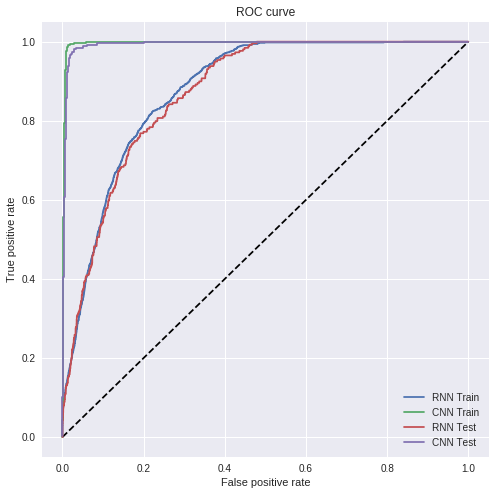

In [0]:
# compute false and true positive rates for ROC curve ~10 mins
fpr_rnn_train, tpr_rnn_train, _ = roc_curve(y_train, char_rnn.predict(X_train))
fpr_cnn_train, tpr_cnn_train, _ = roc_curve(y_train, char_cnn.predict(X_train))
fpr_rnn_test, tpr_rnn_test, _ = roc_curve(y_test, char_rnn.predict(X_test))
fpr_cnn_test, tpr_cnn_test, _ = roc_curve(y_test, char_cnn.predict(X_test))

# plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn_train, tpr_rnn_train, label = 'RNN Train')
plt.plot(fpr_cnn_train, tpr_cnn_train, label = 'CNN Train')
plt.plot(fpr_rnn_test, tpr_rnn_test, label = 'RNN Test')
plt.plot(fpr_cnn_test, tpr_cnn_test, label = 'CNN Test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Both models were able to reach training and test accuracies of at least 98%. However, the ROC curves for the RNN model do not look that great. It seems that the CNN model outperformed the RNN model for this problem. Let's take a closer look at our data.

In [0]:
# number of benign URLs
len(benignURL)

66015

In [0]:
# number of malicious URLs
len(maliciousURL)

1296

Our dataset is very unbalanced. A model can easily achieve similar accuracy results by just predicting each URL as benign. Let's try retraining these models with a balanced dataset.

In [0]:
# use a subsample of benign URLs, so the new datset has the same number of benign and malicious URLs
sample_indx = np.random.randint(len(benignURL), size=len(maliciousURL), dtype='int64')
benignURL_sample = list(np.array(benignURL)[sample_indx])

In [0]:
# number of benign URLs kept
len(benignURL_sample)

1296

In [0]:
# label 1 if malicious and 0 if benign
label = [0]*len(benignURL_sample)+[1]*len(maliciousURL)
URL = benignURL_sample+maliciousURL
len(label)

2592

Our new dataset is much smaller but it is more balanced. It'll be more difficult for our models to achieve high accuracy scores without *learning*.

In [0]:
# regenerate zero matrix and convert URLs to numerical representation
X = np.zeros((len(URL), maxlen, len(chars)), dtype=np.uint8)
for i, seq in enumerate(URL):
    for t, char in enumerate(seq):
        X[i, t, char_indices[char]] = 1

In [0]:
# shape of new data
X.shape

(2592, 86, 67)

In [0]:
# split data into train-test split
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=2)

In [0]:
# rebuild model
char_rnn2 = Sequential()
char_rnn2.add(LSTM(100, input_shape=(maxlen, len(chars)),  return_sequences = True))
char_rnn2.add(LSTM(50))
char_rnn2.add(Dropout(0.25))
char_rnn2.add(Dense(100, activation='relu'))
char_rnn2.add(Dropout(0.25))
char_rnn2.add(Dense(1, activation="sigmoid"))
char_rnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 86, 100)           67200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile model
char_rnn2.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=["acc"])

In [0]:
# ~2 mins to train
char_rnn2.fit(X_train, y_train, epochs=10, batch_size=100,
                validation_data=(X_test, y_test))

Train on 2073 samples, validate on 519 samples
Epoch 1/10
2073/2073 [==============================] - 13s 6ms/step - loss: 0.6953 - acc: 0.5596 - val_loss: 0.6735 - val_acc: 0.5530
Epoch 2/10
2073/2073 [==============================] - 11s 5ms/step - loss: 0.6014 - acc: 0.6927 - val_loss: 0.5225 - val_acc: 0.7592
Epoch 3/10
2073/2073 [==============================] - 11s 5ms/step - loss: 0.4968 - acc: 0.7829 - val_loss: 0.5113 - val_acc: 0.7476
Epoch 4/10
2073/2073 [==============================] - 11s 5ms/step - loss: 0.3995 - acc: 0.8297 - val_loss: 0.3409 - val_acc: 0.8593
Epoch 5/10
2073/2073 [==============================] - 11s 5ms/step - loss: 0.3930 - acc: 0.8370 - val_loss: 0.3094 - val_acc: 0.8748
Epoch 6/10
2073/2073 [==============================] - 11s 5ms/step - loss: 0.3458 - acc: 0.8538 - val_loss: 0.4062 - val_acc: 0.8459
Epoch 7/10
2073/2073 [==============================] - 11s 5ms/step - loss: 0.3370 - acc: 0.8731 - val_loss: 0.3311 - val_acc: 0.8882
Epoch 8/

In [0]:
# rebuild model
char_cnn2 = Sequential()
char_cnn2.add(Conv1D(filters = 32, kernel_size=15, 
                 activation='relu', strides=1, 
                 padding='valid',
                 input_shape=(maxlen, len(chars))))
char_cnn2.add(Conv1D(filters = 32, kernel_size=10, 
                 activation='relu', strides=1, 
                 padding='valid'))
char_cnn2.add(MaxPooling1D(pool_size=5))
char_cnn2.add(Dropout(0.25))
char_cnn2.add(Flatten())
char_cnn2.add(Dense(150, activation='relu'))
char_cnn2.add(Dropout(0.25))
char_cnn2.add(Dense(1, activation='sigmoid'))
char_cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 72, 32)            32192     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 63, 32)            10272     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 32)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 150)               57750     
_________________________________________________________________
dropout_12 (Dropout)         (None, 150)               0         
__________

In [0]:
# compile model
char_cnn2.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=["acc"])

In [0]:
# ~1 min to train
char_cnn2.fit(X_train, y_train, epochs=10, batch_size=100,
                validation_data=(X_test, y_test))

Train on 2073 samples, validate on 519 samples
Epoch 1/10
2073/2073 [==============================] - 2s 910us/step - loss: 0.4664 - acc: 0.7656 - val_loss: 0.3859 - val_acc: 0.8092
Epoch 2/10
2073/2073 [==============================] - 0s 114us/step - loss: 0.3076 - acc: 0.8746 - val_loss: 0.2790 - val_acc: 0.8960
Epoch 3/10
2073/2073 [==============================] - 0s 112us/step - loss: 0.2071 - acc: 0.9204 - val_loss: 0.1923 - val_acc: 0.9287
Epoch 4/10
2073/2073 [==============================] - 0s 117us/step - loss: 0.1423 - acc: 0.9518 - val_loss: 0.1626 - val_acc: 0.9499
Epoch 5/10
2073/2073 [==============================] - 0s 114us/step - loss: 0.1113 - acc: 0.9624 - val_loss: 0.1302 - val_acc: 0.9672
Epoch 6/10
2073/2073 [==============================] - 0s 112us/step - loss: 0.0918 - acc: 0.9715 - val_loss: 0.1389 - val_acc: 0.9499
Epoch 7/10
2073/2073 [==============================] - 0s 116us/step - loss: 0.0615 - acc: 0.9817 - val_loss: 0.1033 - val_acc: 0.9692
E

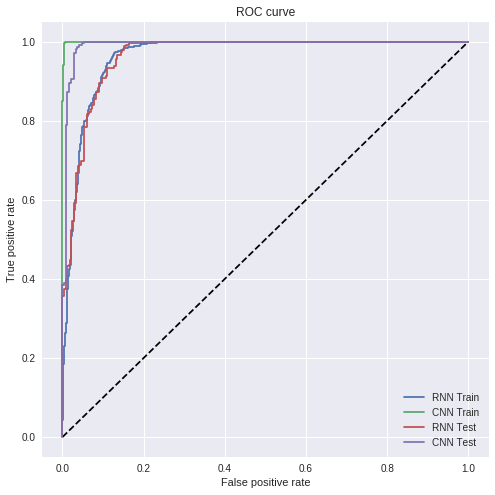

In [0]:
# compute false and true positive rates for ROC curve
fpr_rnn_train, tpr_rnn_train, _ = roc_curve(y_train, char_rnn2.predict(X_train))
fpr_cnn_train, tpr_cnn_train, _ = roc_curve(y_train, char_cnn2.predict(X_train))
fpr_rnn_test, tpr_rnn_test, _ = roc_curve(y_test, char_rnn2.predict(X_test))
fpr_cnn_test, tpr_cnn_test, _ = roc_curve(y_test, char_cnn2.predict(X_test))

# plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn_train, tpr_rnn_train, label = 'RNN Train')
plt.plot(fpr_cnn_train, tpr_cnn_train, label = 'CNN Train')
plt.plot(fpr_rnn_test, tpr_rnn_test, label = 'RNN Test')
plt.plot(fpr_cnn_test, tpr_cnn_test, label = 'CNN Test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

The CNN model still outperformed the RNN model using our new balanced dataset. These ROC curves for the RNN model however look much better. Since it couldn't *cheat* by predicting the predominant label, it was forced to *learn* in order to minimize the loss function.